# Vsebina projektne naloge

Cilj projektne naloge je uporabiti in dodatno nadgraditi znanja, ki ste jih osvojili tekom izdelave sprotnih nalog. V sklopu projektne naloge se boste spoprijeli z izzivom regresijskega problema, natančneje z napovedovanjem časovnih vrst. V tem primeru bo šlo za realne meritve kvalitete zraka, vaš cilj pa bo čim natančneje napovedati vrednost parametra pm10.

In [1602]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import boxcox, yeojohnson
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.wrappers.scikit_learn import KerasRegressor

In [1603]:
df = pd.read_csv('data/RV2_UPP_IIR_SIPIA.csv')

In [1604]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=["Date"], inplace=True)

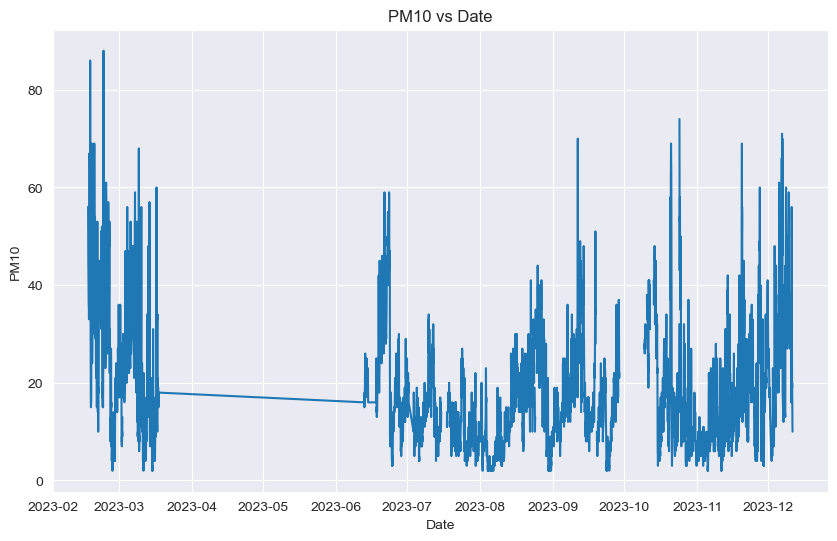

In [1605]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['PM10'])
plt.xlabel('Date')
plt.ylabel('PM10')
plt.title('PM10 vs Date')
plt.show()

In [1606]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
72,2023-02-15 19:35:00+00:00,46.5592,15.656191,270.0,47.0,47.0,0,56.0
78,2023-02-15 20:15:00+00:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0
79,2023-02-15 20:35:00+00:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0
153,2023-02-15 21:15:00+00:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0
154,2023-02-15 21:35:00+00:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0


In [1607]:
df.tail()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
1880,2023-12-11 04:35:00+00:00,46.5592,15.656191,270.0,27.0,19.0,0,20.0
2633,2023-12-11 05:35:00+00:00,46.5592,15.656191,270.0,29.0,15.0,0,16.0
3067,2023-12-11 06:35:00+00:00,46.5592,15.656191,270.0,28.0,12.0,0,13.0
3548,2023-12-11 07:35:00+00:00,46.5592,15.656191,270.0,33.0,9.0,0,11.0
3844,2023-12-11 08:35:00+00:00,46.5592,15.656191,270.0,39.0,8.0,0,10.0


In [1608]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5625 entries, 72 to 3844
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       5625 non-null   datetime64[ns, UTC]
 1   Latitude   5625 non-null   float64            
 2   Longitude  5625 non-null   float64            
 3   Altitude   5625 non-null   float64            
 4   NO2        5339 non-null   float64            
 5   PM2.5      5160 non-null   float64            
 6   O3         5625 non-null   int64              
 7   PM10       5159 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 395.5 KB


In [1609]:
df_weather = pd.read_csv('data/weather.csv')
df_weather.head()

,Date,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-01-01 00:15:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
1,2023-01-01 00:35:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
2,2023-01-01 01:15:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
3,2023-01-01 01:35:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
4,2023-01-01 02:15:00+00:00,4.8,92.0,3.6,1.9,0.0,0.0,0.0,992.5,10.0,9.2,141.0,1.8,0.356,0.0


In [1610]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'], utc=True)

In [1611]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17518 entries, 0 to 17517
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   Date                            17518 non-null  datetime64[ns, UTC]
 1   temperature_2m (°C)             17518 non-null  float64            
 2   relative_humidity_2m (%)        17518 non-null  float64            
 3   dew_point_2m (°C)               17518 non-null  float64            
 4   apparent_temperature (°C)       17518 non-null  float64            
 5   precipitation (mm)              17518 non-null  float64            
 6   rain (mm)                       17518 non-null  float64            
 7   snowfall (cm)                   17518 non-null  float64            
 8   surface_pressure (hPa)          17518 non-null  float64            
 9   cloud_cover (%)                 17518 non-null  float64            
 10  wind_speed

In [1612]:
df = pd.merge(df, df_weather, on='Date', how='left')
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-02-15 19:35:00+00:00,46.5592,15.656191,270.0,47.0,47.0,0,56.0,0.5,91.0,...,0.0,0.0,0.0,996.8,0.0,8.0,190.0,0.4,0.348,0.0
1,2023-02-15 20:15:00+00:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
2,2023-02-15 20:35:00+00:00,46.5592,15.656191,270.0,40.0,49.0,0,56.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
3,2023-02-15 21:15:00+00:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0
4,2023-02-15 21:35:00+00:00,46.5592,15.656191,270.0,31.0,44.0,0,49.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0


# Predprocesiranje podatkov

Zapolnjevanje manjkajočih vrednosti 

In [1613]:
df.isnull().sum()

Date                                0
Latitude                            0
Longitude                           0
Altitude                            0
NO2                               286
PM2.5                             465
O3                                  0
PM10                              466
temperature_2m (°C)                 1
relative_humidity_2m (%)            1
dew_point_2m (°C)                   1
apparent_temperature (°C)           1
precipitation (mm)                  1
rain (mm)                           1
snowfall (cm)                       1
surface_pressure (hPa)              1
cloud_cover (%)                     1
wind_speed_10m (km/h)               1
wind_direction_10m (°)              1
soil_temperature_0_to_7cm (°C)      1
soil_moisture_0_to_7cm (m³/m³)      1
is_day ()                           1
dtype: int64

In [1614]:
cols_to_fill = df.columns[df.isnull().any()].tolist()
print(cols_to_fill)

['NO2', 'PM2.5', 'PM10', 'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)', 'rain (mm)', 'snowfall (cm)', 'surface_pressure (hPa)', 'cloud_cover (%)', 'wind_speed_10m (km/h)', 'wind_direction_10m (°)', 'soil_temperature_0_to_7cm (°C)', 'soil_moisture_0_to_7cm (m³/m³)', 'is_day ()']


In [1615]:
for col in cols_to_fill:
    incomplete_rows = df[df[col].isnull()]
    complete_rows = df[~df[col].isnull()]

    # Features and target columns excluding 'Date'
    features = [c for c in df.columns if c != col and c != 'Date']
    target = col

    X_train = complete_rows[features]
    y_train = complete_rows[target]

    model = HistGradientBoostingRegressor()

    model.fit(X_train, y_train)

    predicted_values = model.predict(incomplete_rows[features])

    df.loc[df[col].isnull(), col] = predicted_values

In [1616]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
dtype: int64

# Informations gain

In [1617]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5                             1.263609
soil_moisture_0_to_7cm (m³/m³)    0.433245
soil_temperature_0_to_7cm (°C)    0.278841
apparent_temperature (°C)         0.267303
NO2                               0.254776
surface_pressure (hPa)            0.254459
dew_point_2m (°C)                 0.253805
temperature_2m (°C)               0.235176
wind_direction_10m (°)            0.175160
wind_speed_10m (km/h)             0.147613
Name: Information Gain Scores, dtype: float64

<Axes: >

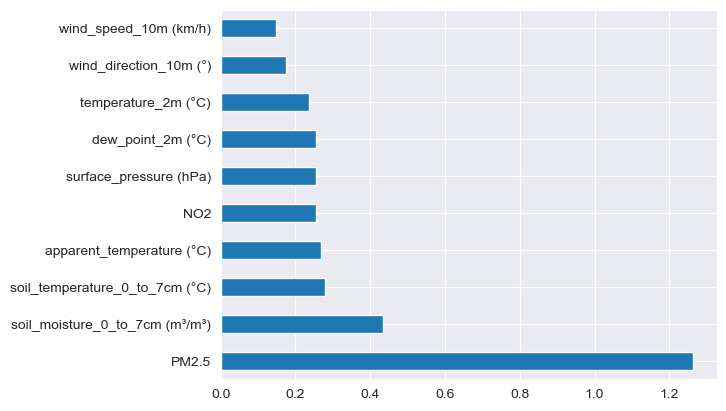

In [1618]:
feature_importances.head(10).plot.barh()

Transformacija podatkov

In [1619]:
def boxcox_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Box-Cox")

    # transform data
    data = boxcox(df[column], lmbda=0.0)

    # create after plots
    sns.distplot(data, ax=ax[1])
    ax[1].set_title("After Box-Cox")

    # update dataframe
    df[column] = data

    plt.show()


In [1620]:
def yeojohnson_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Yeo-Johnson")

    # transform data
    data = yeojohnson(df[column])

    # create after plots
    sns.distplot(data[0], ax=ax[1])
    ax[1].set_title("After Yeo-Johnson")

    # update dataframe
    df[column] = data[0]

    plt.show()

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

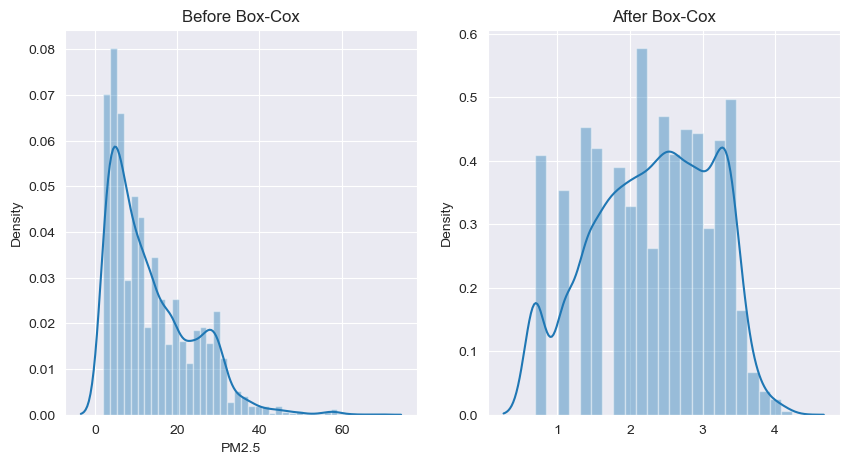

In [1621]:
boxcox_transform('PM2.5')

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

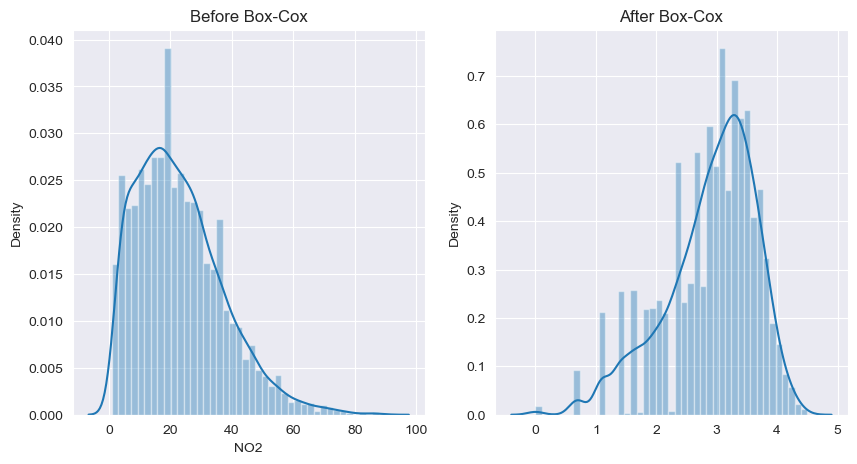

In [1622]:
boxcox_transform('NO2')

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

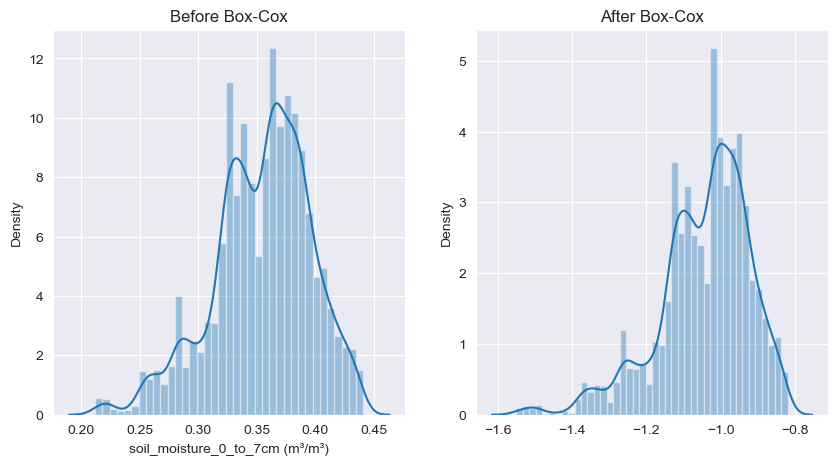

In [1623]:
boxcox_transform("soil_moisture_0_to_7cm (m³/m³)")

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

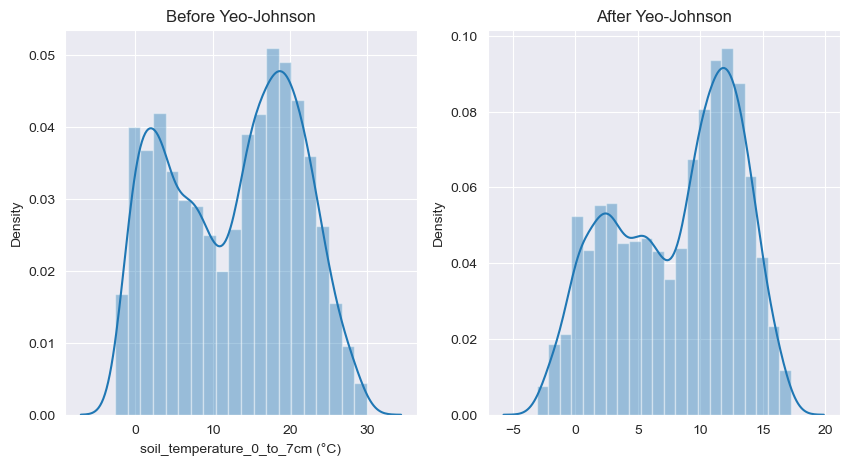

In [1624]:
yeojohnson_transform("soil_temperature_0_to_7cm (°C)")

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

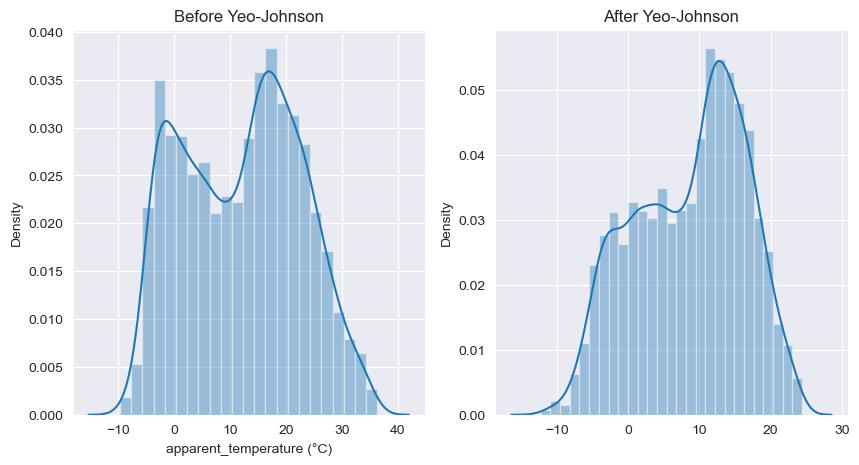

In [1625]:
yeojohnson_transform("apparent_temperature (°C)")

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/2935021008.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

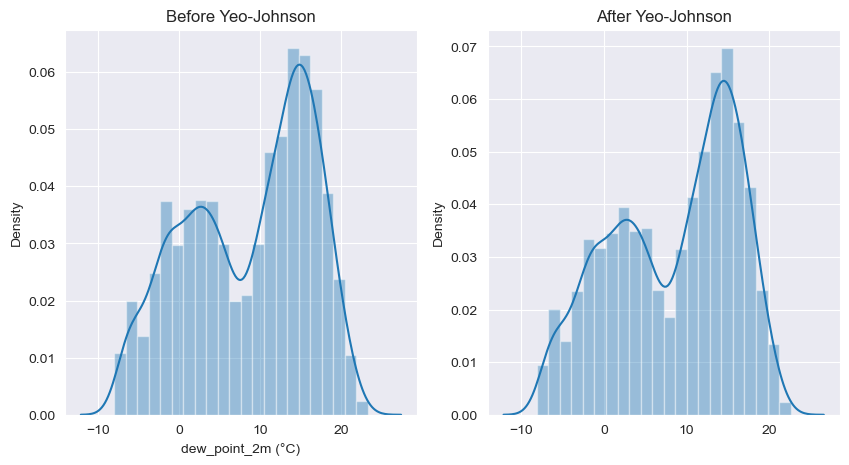

In [1626]:
yeojohnson_transform("dew_point_2m (°C)")

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_34006/3321678299.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code t

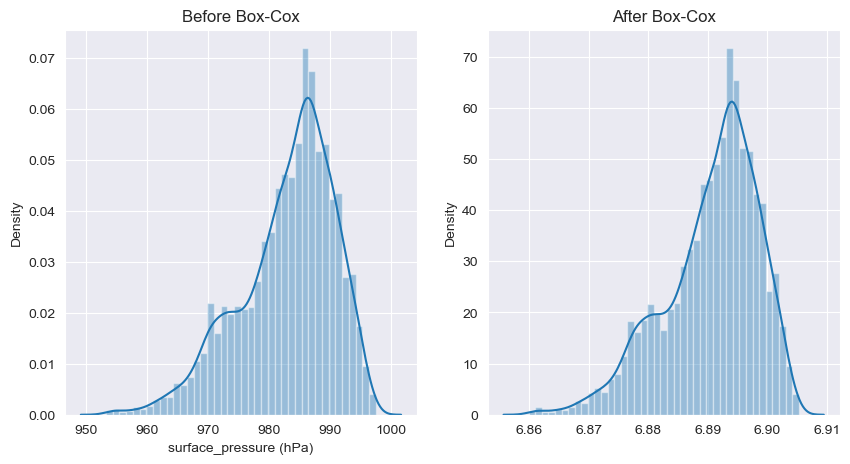

In [1627]:
boxcox_transform("surface_pressure (hPa)")

## Normalizacija/Standardizacija podatkov

**When to Use:**
- Use standardization when the distribution of your data is Gaussian-like and you have features with different units or different scales. It's robust to outliers and doesn't bound values to a specific range.

- Use normalization when your data doesn't follow a Gaussian distribution, or when you're working with algorithms that require data in a specific range (like neural networks).

In [1628]:
columns_to_normalize = ['PM2.5', 'NO2']
columns_to_standardize = ['soil_moisture_0_to_7cm (m³/m³)', 'soil_temperature_0_to_7cm (°C)',
                          'apparent_temperature (°C)', 'dew_point_2m (°C)', 'surface_pressure (hPa)']

min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

df[columns_to_normalize] = min_max_scaler.fit_transform(df[columns_to_normalize])
df[columns_to_standardize] = standard_scaler.fit_transform(df[columns_to_standardize])

# Izdelava modela

In [1629]:
target_variable = 'PM10'

features = columns_to_normalize + columns_to_standardize
selected_features = features + [target_variable]

data = df[selected_features]

In [1630]:
def create_time_series(data, window_size=48):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # Features
        y.append(data[i + window_size, -1])  # Target variable
    return np.array(X), np.array(y)


In [1631]:
days = 1
window_size = 48 * days  # od 0:15 do 0:15 naslednjega dne je 48 meritev

In [1632]:
# test_size = 0.2
# train_data, test_data = train_test_split(data, test_size=test_size, shuffle=False)

In [1633]:
time_series = data.values

In [1634]:
test_data_size = 48 * 7
train_data = time_series[:-test_data_size]
test_data = time_series[-test_data_size:]

In [1635]:
X_train, y_train = create_time_series(train_data, window_size)
X_test, y_test = create_time_series(test_data, window_size)

In [1636]:
# build more models SimpleRNN, GRU
def create_model(units=32, optimizer='adam', activation='relu', batch_size=64, epochs=10):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=units))
    model.add(Dense(units=16, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [1637]:
# param_grid = {
#     'units': [32, 64, 128],
#     'optimizer': ['adam', 'rmsprop'],
#     'activation': ['relu', 'sigmoid'],
#     'batch_size': [64],
#     'epochs': [10]
# }

In [1638]:
# model = KerasRegressor(build_fn=create_model, verbose=1)
# grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
#                           scoring='neg_mean_squared_error', cv=3, n_iter=3,
#                           random_state=1234)
# grid_result = grid.fit(X_train, y_train, verbose=1)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [1639]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


In [1640]:
#best_model = grid_result.best_estimator_.model
best_model = create_model(units=128, optimizer='adam', activation='relu', batch_size=64, epochs=10)
best_model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
82/82 [==============================] - 7s 74ms/step - loss: 261.4378
Epoch 2/10
82/82 [==============================] - 6s 74ms/step - loss: 177.2583
Epoch 3/10
82/82 [==============================] - 6s 75ms/step - loss: 177.0292
Epoch 4/10
82/82 [==============================] - 6s 75ms/step - loss: 176.8880
Epoch 5/10
82/82 [==============================] - 6s 74ms/step - loss: 177.1555
Epoch 6/10
82/82 [==============================] - 6s 74ms/step - loss: 164.4063
Epoch 7/10
82/82 [==============================] - 6s 73ms/step - loss: 125.6107
Epoch 8/10
82/82 [==============================] - 6s 73ms/step - loss: 105.0415
Epoch 9/10
82/82 [==============================] - 6s 73ms/step - loss: 351.0424
Epoch 10/10
82/82 [==============================] - 6s 77ms/step - loss: 103.2757


In [1641]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Explained Variance Score:", evs)

9/9 [==============================] - 0s 16ms/step
Mean Absolute Error: 8.839859479003483
Mean Squared Error: 142.91759030583268
Explained Variance Score: 0.3219623167395318


In [1642]:
predicted = best_model.predict(X_test)
predicted = np.reshape(predicted, (predicted.size,))

9/9 [==============================] - 0s 16ms/step


In [1643]:
dates = df['Date'].values

In [1644]:
df_output = pd.DataFrame({'Date': dates[-len(y_test):], 'Actual': y_test, 'Predicted': predicted})
df_output.head()

,Date,Actual,Predicted
0,2023-11-29 09:35:00,19.0,10.232183
1,2023-11-29 10:35:00,18.0,11.355186
2,2023-11-29 11:35:00,21.0,11.916267
3,2023-11-29 12:35:00,15.0,12.991690
4,2023-11-29 13:35:00,14.0,13.804323


In [1645]:
def plot_results():
    plt.figure(figsize=(12, 8))
    plt.plot(df_output['Date'], df_output["Actual"], label='Actual')
    plt.plot(df_output['Date'], df_output['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('PM10')
    plt.title('PM10 vs Time')
    plt.legend()
    plt.show()

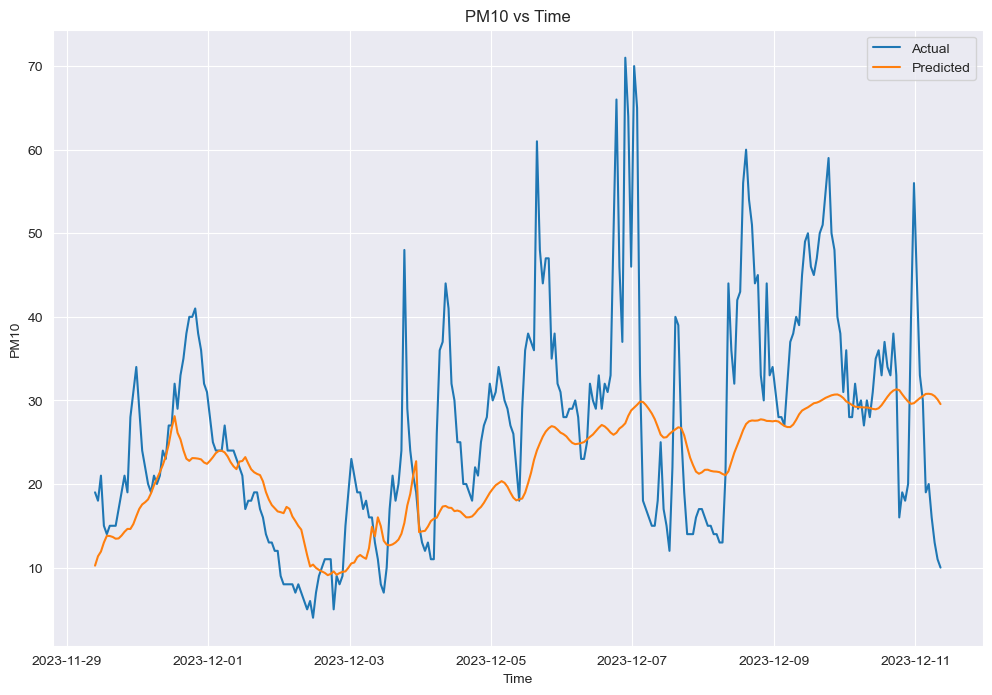

In [1646]:
plot_results()

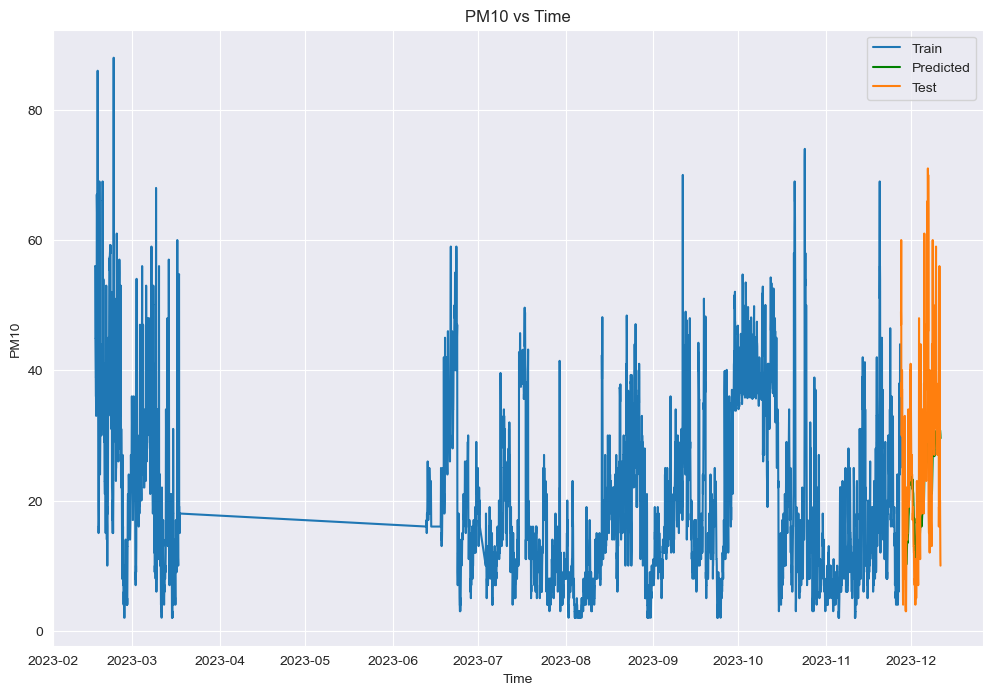

In [1650]:
plt.figure(figsize=(12, 8))
plt.plot(df["Date"].iloc[:-test_data_size], df["PM10"].iloc[:-test_data_size], label='Train')
plt.plot(df_output['Date'], df_output['Predicted'], label='Predicted', color='green')
plt.plot(df["Date"].iloc[-test_data_size:], df["PM10"].iloc[-test_data_size:], label='Test')
plt.xlabel('Time')
plt.ylabel('PM10')
plt.title('PM10 vs Time')
plt.legend()
plt.show()